In [2]:
!pip install uproot awkward 
!pip install xgboost
from uproot_io import Events, View
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import joblib

cheated_5 = Events("CheatedRecoFile_5.root") # testing

In [3]:
""" BDT Training and event classification """

from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import stats
import gc

plt.rcParams.update({'font.size': 12})

model = joblib.load("optimized_11f.pkl")

importances = model.feature_importances_
feature_names = [
    'DBSCAN Correlation',
    'DBSCAN Noise',
    'Best Fit RMS',
    'Angle',
    'Line',
    'ADC Q4',
    'Step Length',
    r'$\text{Initial } \frac{dE}{dr}$',
    'Hit Count',
    'ADC Sum',
    'Hull Density'
]



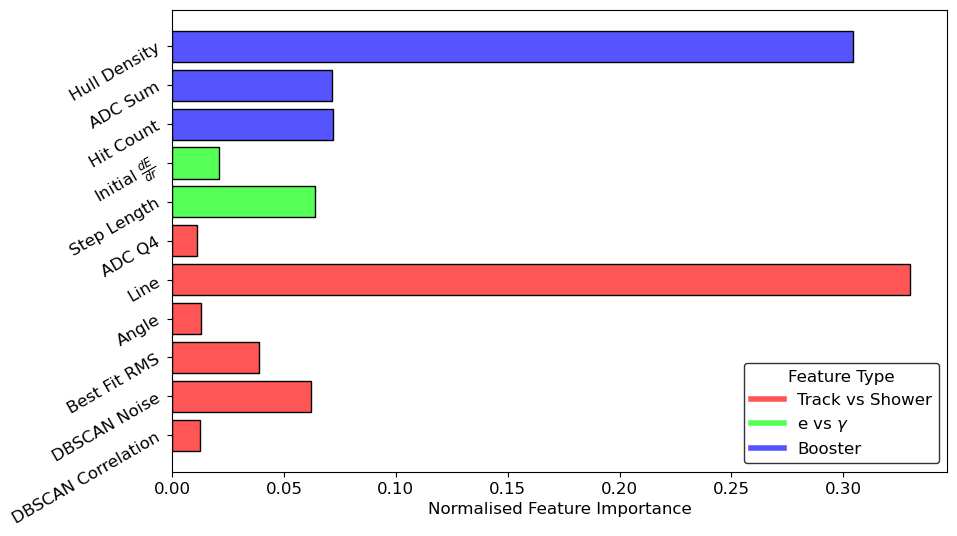

In [4]:
feature_types = [
    'Track vs Shower',
    'Track vs Shower',
    'Track vs Shower',
    'Track vs Shower',
    'Track vs Shower',
    'Track vs Shower',
    r'e vs $\gamma$',
    r'e vs $\gamma$',
    'Booster',
    'Booster',
    'Booster',
]

feature_colours = {
    'Track vs Shower': '#F55',
    r'e vs $\gamma$': '#5F5',
    'Booster': '#55F',
}

bar_colours = [feature_colours[ftype] for ftype in feature_types]

plt.figure(figsize=(10, 6))
bars = plt.barh(np.arange(len(importances)), importances, color=bar_colours, edgecolor='k')
plt.yticks(np.arange(len(importances)), feature_names, rotation=30, ha="right")
plt.xlabel('Normalised Feature Importance')

unique_feature_types = list(feature_colours.keys())
legend_patches = [plt.Line2D([0], [0], color=feature_colours[ftype], lw=4, label=ftype) for ftype in unique_feature_types]
plt.legend(handles=legend_patches, title="Feature Type", loc="lower right", frameon=True, edgecolor='black')
plt.show()

In [5]:
data = np.load("11f_testing_data.npz")
x_test = data["x_test"]
y_test = data["y_test"][:, 1]
indices = data["y_test"][:, 0]

# Step 3: Extract Confidence Values (no need for predictions now)
particle_probs = model.predict_proba(x_test)  # Shape: (num_particles, num_classes) = x_test.shape

# Step 4: Slice confidence values into event subarrays
identifiers = cheated_5.event_number
change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
slices = np.split(np.arange(len(cheated_5.event_number)), change_indices)

print(slices[:10])
print(indices[:50])

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([ 29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
   

In [6]:
clean_slices = [slice_array[np.isin(slice_array, indices)] for slice_array in slices]
clean_slices = [s for s in clean_slices if s.size > 0]

print(clean_slices[:10])

[array([ 0,  1,  2,  3,  4,  5, 22, 26, 27]), array([ 29,  30,  31,  32,  35,  43,  44,  45,  46,  47, 135, 136, 139,
       161, 213, 215, 219, 223, 224, 252]), array([253, 254, 255, 256, 258, 260, 266, 327, 328, 333, 383, 386, 452,
       455, 462, 463, 464, 466, 473, 485, 486, 500, 513, 514, 515, 521,
       570, 571, 575, 576, 577, 578]), array([641, 642, 643, 644, 666, 670, 695, 696, 703, 704, 706, 707, 708,
       709, 729, 730]), array([731, 759, 760]), array([763, 765]), array([767, 768, 780, 803, 804]), array([806, 826, 837, 838, 839, 845, 846, 852, 859, 869, 870, 882, 883,
       890]), array([ 913,  914,  915,  916,  962,  987,  988, 1015, 1016, 1077, 1078]), array([1100, 1101, 1102, 1103, 1122])]


In [7]:
print(x_test.shape)
print(y_test.shape)
print(sum(len(slice_array) for slice_array in clean_slices))

subarray_lengths = [len(slice_array) for slice_array in clean_slices]
split_testing_idx = np.split(np.arange(len(y_test)), np.cumsum(subarray_lengths)[:-1])

print(sum(len(a) for a in split_testing_idx))

(50559, 11)
(50559,)
50559
50559


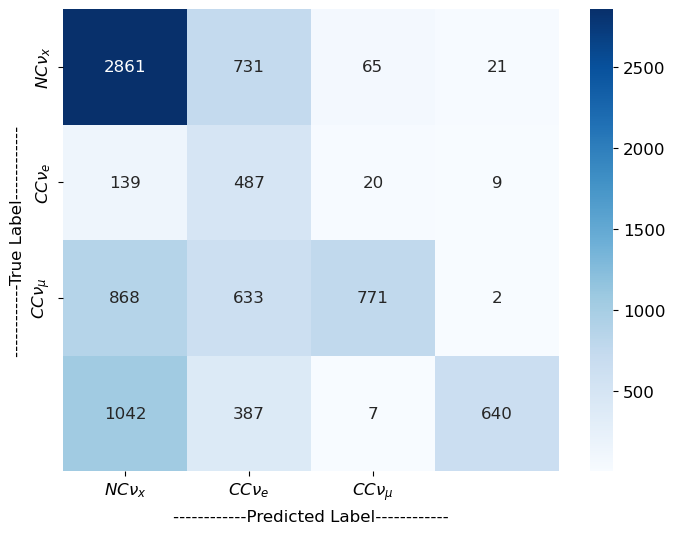

Event-Level Accuracy: 0.5481


In [8]:
confidence_slices = [particle_probs[s] for s in split_testing_idx]  # List of arrays with shape (num_particles_in_event, num_classes)

# Step 5: Weighted Voting for Event Classification
final_event_preds = []
final_event_truths = []

for i, conf_subarray in enumerate(confidence_slices):
    # Sum the confidence values for each class in the event
    class_confidence_sum = np.sum(conf_subarray, axis=0)  # Sum across all particles in the event (for each class)
    
    # Choose the class with the highest summed confidence
    event_pred = np.argmax(class_confidence_sum)
    
    # Get the true label for the event (assume y_test is the true label for particles and you know event labels)
    event_truth = y_test[split_testing_idx[i]][0]  # Take label from first particle
    
    final_event_preds.append(event_pred)
    final_event_truths.append(event_truth)

# Step 6: Plot a Confusion Matrix
# Compute confusion matrix at event level
conf_matrix = confusion_matrix(final_event_truths, final_event_preds)

# Plot confusion matrix
classes = [r'$NC\nu_x$', r'$CC\nu_e$', r'$CC\nu_\mu$']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('------------Predicted Label------------')
plt.ylabel('------------True Label------------')
plt.show()

# Step 7: (Optional) Compute Accuracy
event_accuracy = accuracy_score(final_event_truths, final_event_preds)
print(f"Event-Level Accuracy: {event_accuracy:.4f}")